# Project-1-Spotify

We are a consulting company for independent artists. We are helping a new Mexican artist to launch their next hit in Mexico and Latin America, which is planned to be released in last quarter 2020 in the Spotify platform, to remain in the Top 50 Chart throughout the next year.

Tasks:

* Identify most popular music genres in the population segment that the artist is targeting.
* Identify patterns in the tempo, energy, danceability and acousticness of the music that people in that segment listen to in different quarters.
* Define the properties that the artist's song should have to be succesful in last quarter 2020 in Mexico and Latin America.
* Predict how popular this song will be in upcoming quarters.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

analysis=pd.read_excel("complete_dfr.xlsx")
analysis

,Unnamed: 0,Position,Track Name,Artist,URL_x,Date,id_x,url,danceability,energy,...,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature,Position_I
0,0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,https://open.spotify.com/track/0mb7btREdC3wuIU...,2017-01-01,0mb7btREdC3wuIUmuVRgWn,https://api.spotify.com/v1/audio-features?ids=...,0.579,0.904,...,0.713,175.316,audio_features,0mb7btREdC3wuIUmuVRgWn,spotify:track:0mb7btREdC3wuIUmuVRgWn,NaN,NaN,187853,4,-1
1,1,2,El Año Viejo,Tony Camargo,https://open.spotify.com/track/6NjhADkaWwGYO0R...,2017-01-01,6NjhADkaWwGYO0R7eZXyI4,https://api.spotify.com/v1/audio-features?ids=...,0.740,0.521,...,0.904,159.694,audio_features,6NjhADkaWwGYO0R7eZXyI4,spotify:track:6NjhADkaWwGYO0R7eZXyI4,NaN,NaN,182720,4,-2
2,2,3,La Edad de los Países,Hernán Casciari,https://open.spotify.com/track/5gA5Tvu7zlihzqU...,2017-01-01,5gA5Tvu7zlihzqUvmPUqoi,https://api.spotify.com/v1/audio-features?ids=...,0.606,0.301,...,0.941,62.876,audio_features,5gA5Tvu7zlihzqUvmPUqoi,spotify:track:5gA5Tvu7zlihzqUvmPUqoi,NaN,NaN,280521,3,-3
3,3,4,"Shake It Off - From ""Sing"" Original Motion Pic...",Nick Kroll,https://open.spotify.com/track/2Q0WZoJaRJlelcx...,2017-01-01,2Q0WZoJaRJlelcxqOvowUc,https://api.spotify.com/v1/audio-features?ids=...,0.738,0.906,...,0.831,160.088,audio_features,2Q0WZoJaRJlelcxqOvowUc,spotify:track:2Q0WZoJaRJlelcxqOvowUc,NaN,NaN,120560,4,-4
4,4,5,Another Day Of Sun,La La Land Cast,https://open.spotify.com/track/5kRBzRZmZTXVg8o...,2017-01-01,5kRBzRZmZTXVg8okC7SJFZ,https://api.spotify.com/v1/audio-features?ids=...,0.588,0.742,...,0.824,125.819,audio_features,5kRBzRZmZTXVg8okC7SJFZ,spotify:track:5kRBzRZmZTXVg8okC7SJFZ,NaN,NaN,228173,4,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58845,58845,46,Amor Tumbado,Natanael Cano,https://open.spotify.com/track/5aJ1M43pinROpwa...,2020-03-30,5aJ1M43pinROpwaPnO8KRj,NaN,0.535,0.714,...,0.458,100.059,audio_features,5aJ1M43pinROpwaPnO8KRj,spotify:track:5aJ1M43pinROpwaPnO8KRj,NaN,NaN,221554,3,-46
58846,58846,47,Yo Ya No Vuelvo Contigo - En Vivo,Lenin Ramírez,https://open.spotify.com/track/1s59X35jDULAyOG...,2020-03-30,1s59X35jDULAyOGmBuTAnd,NaN,0.644,0.350,...,0.541,118.206,audio_features,1s59X35jDULAyOGmBuTAnd,spotify:track:1s59X35jDULAyOGmBuTAnd,NaN,NaN,240457,1,-47
58847,58847,48,CITY OF ANGELS,24kGoldn,https://open.spotify.com/track/6ap9lSRJ0iLriGL...,2020-03-30,6ap9lSRJ0iLriGLqoJ44cq,NaN,0.686,0.541,...,0.724,120.084,audio_features,6ap9lSRJ0iLriGLqoJ44cq,spotify:track:6ap9lSRJ0iLriGLqoJ44cq,NaN,NaN,112493,4,-48
58848,58848,49,Savage,Megan Thee Stallion,https://open.spotify.com/track/55CHeLEfn5iJ0II...,2020-03-30,55CHeLEfn5iJ0IIkgaa4si,NaN,0.843,0.741,...,0.680,168.983,audio_features,55CHeLEfn5iJ0IIkgaa4si,spotify:track:55CHeLEfn5iJ0IIkgaa4si,NaN,NaN,155497,4,-49


In [2]:
#Limpieza de datos para quitar la columna Unnamed:0
analysis=analysis.drop(['Unnamed: 0'], axis=1)
analysis.head()

,Position,Track Name,Artist,URL_x,Date,id_x,url,danceability,energy,key,...,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature,Position_I
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,https://open.spotify.com/track/0mb7btREdC3wuIU...,2017-01-01,0mb7btREdC3wuIUmuVRgWn,https://api.spotify.com/v1/audio-features?ids=...,0.579,0.904,10,...,0.713,175.316,audio_features,0mb7btREdC3wuIUmuVRgWn,spotify:track:0mb7btREdC3wuIUmuVRgWn,NaN,NaN,187853,4,-1
1,2,El Año Viejo,Tony Camargo,https://open.spotify.com/track/6NjhADkaWwGYO0R...,2017-01-01,6NjhADkaWwGYO0R7eZXyI4,https://api.spotify.com/v1/audio-features?ids=...,0.740,0.521,0,...,0.904,159.694,audio_features,6NjhADkaWwGYO0R7eZXyI4,spotify:track:6NjhADkaWwGYO0R7eZXyI4,NaN,NaN,182720,4,-2
2,3,La Edad de los Países,Hernán Casciari,https://open.spotify.com/track/5gA5Tvu7zlihzqU...,2017-01-01,5gA5Tvu7zlihzqUvmPUqoi,https://api.spotify.com/v1/audio-features?ids=...,0.606,0.301,9,...,0.941,62.876,audio_features,5gA5Tvu7zlihzqUvmPUqoi,spotify:track:5gA5Tvu7zlihzqUvmPUqoi,NaN,NaN,280521,3,-3
3,4,"Shake It Off - From ""Sing"" Original Motion Pic...",Nick Kroll,https://open.spotify.com/track/2Q0WZoJaRJlelcx...,2017-01-01,2Q0WZoJaRJlelcxqOvowUc,https://api.spotify.com/v1/audio-features?ids=...,0.738,0.906,11,...,0.831,160.088,audio_features,2Q0WZoJaRJlelcxqOvowUc,spotify:track:2Q0WZoJaRJlelcxqOvowUc,NaN,NaN,120560,4,-4
4,5,Another Day Of Sun,La La Land Cast,https://open.spotify.com/track/5kRBzRZmZTXVg8o...,2017-01-01,5kRBzRZmZTXVg8okC7SJFZ,https://api.spotify.com/v1/audio-features?ids=...,0.588,0.742,8,...,0.824,125.819,audio_features,5kRBzRZmZTXVg8okC7SJFZ,spotify:track:5kRBzRZmZTXVg8okC7SJFZ,NaN,NaN,228173,4,-5


In [3]:
counta=analysis.groupby(['Artist','Track Name']).size()
count2019=analysis[(analysis['Date']>'2018-12-31') & (analysis['Date']<'2020-01-01')]
count2019=count2019.groupby(['Artist','Track Name']).size().reset_index(name="Number of days in Top 50 Chart")
count2019

,Artist,Track Name,Number of days in Top 50 Chart
0,21 Savage,a lot,27
1,4 Elementos,Cypher #1 (Reggae Cypher),29
2,5 Seconds of Summer,Lie To Me (feat. Julia Michaels),5
3,6ix9ine,MALA (feat. Anuel Aa),16
4,A Boogie Wit da Hoodie,Look Back At It,19
...,...,...,...
794,benny blanco,"I Can’t Get Enough (benny blanco, Selena Gomez...",21
795,blackbear,hot girl bummer,9
796,deadman 死人,Omae Wa Mou,13
797,j-hope,Chicken Noodle Soup (feat. Becky G),9


My first analysis was to observe the life of a song on the Hit Parade. At a first instance to the data I came to know that there was a particular song that had been for more than a year on the list.
So, a Boxplot Analysis would let me observe if the song is an outlier.

In [4]:
#Cuenta cuantas veces aparece la canción en el Top 50 de Spotify
count=analysis.groupby(['Artist','Track Name']).size().reset_index(name="Number of days in Top 50 Chart")
count.head()

,Artist,Track Name,Number of days in Top 50 Chart
0,( Me Llamo ) Sebastián,Baila como hombre,23
1,(G)I-DLE,LATATA,12
2,21 Savage,Bank Account,3
3,21 Savage,a lot,27
4,24kGoldn,CITY OF ANGELS,23


In [5]:
lista = count2019["Number of days in Top 50 Chart"].tolist()

In [8]:
countl=count2019['Number of days in Top 50 Chart']
quartiles =countl.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
average=count2019['Number of days in Top 50 Chart'].mean()

print(f"The lower quartile life of a song in Top 50 chart is: {lowerq}")
print(f"The upper quartile life of a songs in Top 50 chart is: {upperq}")
print(f"The interquartile range life of a song in Top 50 chart is: {iqr}")
print(f"The the median life of a song in Top 50 is: {quartiles[0.5]} ")

print(f"The average life of a song in Top 50 in 2019 is: {average}")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile life of a song in Top 50 chart is: 6.0
The upper quartile life of a songs in Top 50 chart is: 26.0
The interquartile range life of a song in Top 50 chart is: 20.0
The the median life of a song in Top 50 is: 12.0 
The average life of a song in Top 50 in 2019 is: 22.425531914893618
Values below -24.0 could be outliers.
Values above 56.0 could be outliers.


In [9]:
#This is a Hit Summary groupby were we can see the track name,and the position through the timeline
chart=analysis.groupby(['Artist','Date', 'Track Name','Position']).mean()
chart

danceability  \
Artist                 Date       Track Name        Position                 
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1                0.711   
                       2017-08-15 Baila como hombre 1                0.711   
                       2017-08-16 Baila como hombre 2                0.711   
                       2017-08-17 Baila como hombre 1                0.711   
                       2017-08-18 Baila como hombre 1                0.711   
...                                                                    ...   
マジカル・クラウズ              2017-01-20 Downtown          15               0.372   
                       2017-01-21 Downtown          24               0.372   
                       2017-01-22 Downtown          21               0.372   
                       2017-01-24 Downtown          42               0.372   
                       2017-01-25 Downtown          37               0.372   

                                                              energy  key  \
Artist                 Date       Track Name        Position                
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1          0.528    9   
                       2017-08-15 Baila como hombre 1          0.528    9   
                       2017-08-16 Baila como hombre 2          0.528    9   
                       2017-08-17 Baila como hombre 1          0.528    9   
                       2017-08-18 Baila como hombre 1          0.528    9   
...                                                              ...  ...   
マジカル・クラウズ              2017-01-20 Downtown          15         0.262    6   
                       2017-01-21 Downtown          24         0.262    6   
                       2017-01-22 Downtown          21         0.262    6   
                       2017-01-24 Downtown          42         0.262    6   
                       2017-01-25 Downtown          37         0.262    6   

                                                              loudness  mode  \
Artist                 Date       Track Name        Position                   
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1           -7.341     0   
                       2017-08-15 Baila como hombre 1           -7.341     0   
                       2017-08-16 Baila como hombre 2           -7.341     0   
                       2017-08-17 Baila como hombre 1           -7.341     0   
                       2017-08-18 Baila como hombre 1           -7.341     0   
...                                                                ...   ...   
マジカル・クラウズ              2017-01-20 Downtown          15          -9.030     1   
                       2017-01-21 Downtown          24          -9.030     1   
                       2017-01-22 Downtown          21          -9.030     1   
                       2017-01-24 Downtown          42          -9.030     1   
                       2017-01-25 Downtown          37          -9.030     1   

                                                              speechiness  \
Artist                 Date       Track Name        Position                
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1              0.0408   
                       2017-08-15 Baila como hombre 1              0.0408   
                       2017-08-16 Baila como hombre 2              0.0408   
                       2017-08-17 Baila como hombre 1              0.0408   
                       2017-08-18 Baila como hombre 1              0.0408   
...                                                                   ...   
マジカル・クラウズ              2017-01-20 Downtown          15             0.0290   
                       2017-01-21 Downtown          24             0.0290   
                       2017-01-22 Downtown          21             0.0290   
                       2017-01-24 Downtown          42             0.0290   
                       2017-01-25 Downtown          37             0.0290   

  

In [10]:
graph2019=analysis[(analysis['Date']>'2018-12-31') & (analysis['Date']<'2020-01-01')]
filet1=graph2019[(graph2019['Artist']=='Kim Loaiza') & (graph2019['Track Name']=='Amándote')]
filet2=graph2019[(graph2019['Artist']=='Julión Álvarez & Su Norteño Banda') & (graph2019['Track Name']=='Más Te Recuerdo')]
filet3=graph2019[(graph2019['Artist']=='Harry Styles') & (graph2019['Track Name']=='Watermelon Sugar')]
filet4=graph2019[(graph2019['Artist']=='Mamamoo') & (graph2019['Track Name']=='HIP')]
y1=filet1['Position_I']
y2=filet2['Position_I']
y3=filet3['Position_I']
y4=filet4['Position_I']
x=filet1['Date']

The graph below shows the life of a hit song during the top chart

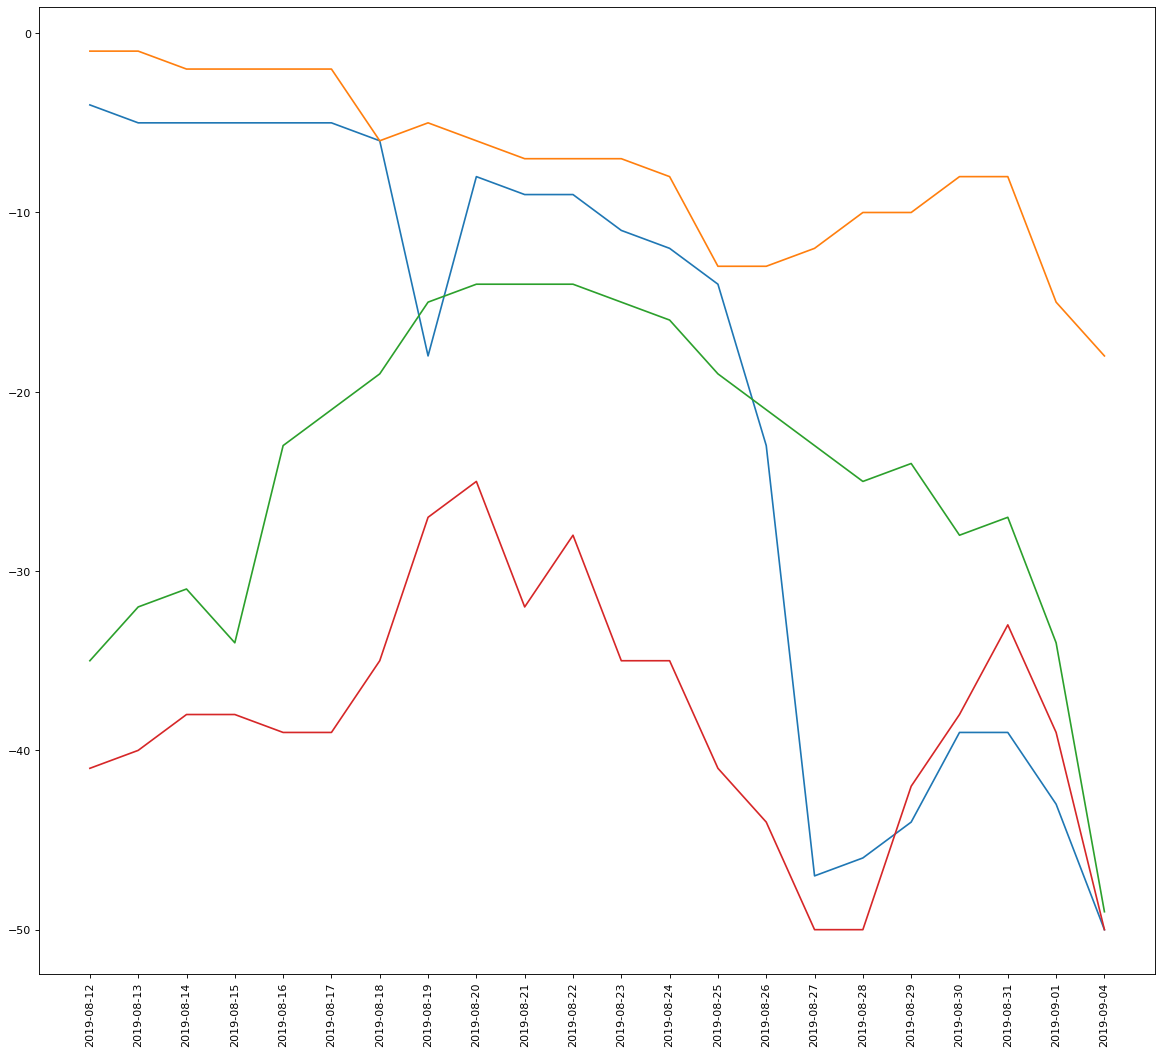

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#For all Matplotlib plots, we start by creating a figure and an axes. In their simplest form, a figure 
#and axes can be created as follows:

fig=plt.figure(figsize=(18, 16), dpi= 80) #, facecolor='w', edgecolor='k')
ax = plt.axes()

x.astype('datetime64[ns]')

plt.xticks(rotation=90)

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)



The charts below divides the hit list by year and quarters. I have found that during mother's day there is a song that hits the top chart each year, during the third quarter themes related to Halloween and Dia de Muertos lyrics are more popular, where as during the last quarter Christmas lyrics are more popular

In [13]:
filet_by_4q2017=analysis[(analysis['Date']>'2017-09-30') & (analysis['Date']<'2018-01-01')]
filet_by_4q2018=analysis[(analysis['Date']>'2018-09-30') & (analysis['Date']<'2019-01-01')]
filet_by_4q2019=analysis[(analysis['Date']>'2019-09-30') & (analysis['Date']<'2020-01-01')]

In [14]:
count02=filet_by_4q2017.groupby(['Artist','Track Name']).size()
count03=filet_by_4q2018.groupby(['Artist','Track Name']).size()
count04=filet_by_4q2019.groupby(['Artist','Track Name']).size()

In [15]:
filet_by_2q2017=analysis[(analysis['Date']>'2017-03-31') & (analysis['Date']<'2017-07-01')]
filet_by_2q2018=analysis[(analysis['Date']>'2018-03-31') & (analysis['Date']<'2018-07-01')]
filet_by_2q2019=analysis[(analysis['Date']>'2019-03-31') & (analysis['Date']<'2019-07-01')]

In [16]:
filet_by_1q2017=analysis[(analysis['Date']>'2016-12-31') & (analysis['Date']<'2017-04-01')]
filet_by_1q2018=analysis[(analysis['Date']>'2017-12-31') & (analysis['Date']<'2018-04-01')]
filet_by_1q2019=analysis[(analysis['Date']>'2018-12-31') & (analysis['Date']<'2019-04-01')]
filet_by_1q2020=analysis[(analysis['Date']>'2019-12-31') & (analysis['Date']<'2020-04-01')]

In [17]:
count08=filet_by_1q2017.groupby(['Artist','Track Name']).size()
count09=filet_by_1q2018.groupby(['Artist','Track Name']).size()
count10=filet_by_1q2019.groupby(['Artist','Track Name']).size()
count11=filet_by_1q2020.groupby(['Artist','Track Name']).size()

In [18]:
filet_by_3q2017=analysis[(analysis['Date']>'2017-06-30') & (analysis['Date']<'2017-10-01')]
filet_by_3q2018=analysis[(analysis['Date']>'2018-06-30') & (analysis['Date']<'2018-10-01')]
filet_by_3q2019=analysis[(analysis['Date']>'2019-06-30') & (analysis['Date']<'2019-10-01')]

In [19]:
count12=filet_by_3q2017.groupby(['Artist','Track Name']).size()
count13=filet_by_3q2018.groupby(['Artist','Track Name']).size()
count14=filet_by_3q2019.groupby(['Artist','Track Name']).size()

## Data preparation

In [20]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import csv

#Import Top 50 chart and Stats table. Get track ID from URL.
top50_chart_df = pd.read_excel("chartmx_03_20.xlsx", index = False)
stats_df = pd.read_excel("audiofmx.xlsx", index = False)

top50_chart_df["id"] = top50_chart_df["URL"].str[-22:]


In [21]:
#Select columns from both Data Frames
top50_chart_df = top50_chart_df[["Position", "Track Name", "Artist", "Date", "id"]]
stats_df = stats_df[["acousticness", "danceability", "duration_ms", "energy", "id", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]

In [22]:
#Import genre data set from 'tsv' file as list.
genres_tsv = os.path.join("songDb.tsv")
with open(genres_tsv, "r") as csvfile:
    csvreader = csv.reader(csvfile, delimiter = "\t")
    genres_data = list(csvreader)

#Remove empty rows from original list.
genres_data_clean = []
for element in genres_data:
    if element != []:
        genres_data_clean.append(element)

#Convert original data set to Pandas DataFrame and promote first row as header.
genres_df = pd.DataFrame(genres_data_clean)
new_header = genres_df.iloc[0]
genres_df = genres_df[1:]
genres_df.columns = new_header
genres_df = genres_df.rename(columns = {"ID": "id"})
genres_df = genres_df[["id", "Genre"]]

In [23]:
#Merge Top 50 chart DataFrame with stats DataFrame in `complete_df` DataFrame.
complete_df = top50_chart_df.merge(stats_df, on = "id")
complete_df = complete_df[["Position", "Track Name", "Artist", "Date", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence", "id"]]

#Merge `complete_df` DataFrame with genre DataFrame. Remove NA's
complete_df = complete_df.merge(genres_df, on = "id")
complete_df = complete_df.dropna()
complete_df.head()

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence,id,Genre
0,7,Hear Me Now,Alok,2017-01-01,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
1,7,Hear Me Now,Alok,2017-01-02,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
2,10,Hear Me Now,Alok,2017-01-03,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
3,11,Hear Me Now,Alok,2017-01-04,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
4,14,Hear Me Now,Alok,2017-01-05,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism


**Hypothesis: If we determine the optimal mix of the variables related to a successful song in Mexico, then we can help the artist release a successful song in the last quarter of 2020:**

**If the tempo of a song is higher than 100 bpm, then it will be more popular.**

We will start by characterizing the tempos in 70 equally spaced bins.

In [24]:
def bins_list (min, max, bins):
    
    # Returns an array containing enough numbers to evenly cut in bins a range of numbers. 
    
    values = []
    x = min
    step = (max - min) / bins
    while x <= max:
        values.append(x)
        x += step
        
    return values

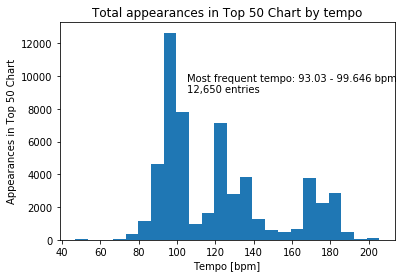

,Stat,Value
0,Max. Tempo,212.117000
1,Min. Tempo,46.718000
2,Mean,121.223503
3,Median,114.011000


In [25]:
tempo_min = complete_df["tempo"].min()
tempo_max = complete_df["tempo"].max()

tempo_bins = bins_list(tempo_min, tempo_max, 25)

complete_mean = complete_df["tempo"].mean()
complete_mode = complete_df["tempo"].mode()
complete_median = complete_df["tempo"].median()


tempo_category = pd.cut(complete_df["tempo"], bins = tempo_bins)
complete_df["Tempo Category"] = tempo_category
plt.hist(complete_df["tempo"], tempo_bins)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Appearances in Top 50 Chart")
plt.title("Total appearances in Top 50 Chart by tempo")
plt.text(105, 9000, "Most frequent tempo: 93.03 - 99.646 bpm\n12,650 entries")
plt.show()

complete_stats_dict = {"Stat": ["Max. Tempo", "Min. Tempo", "Mean", "Median"], "Value": [tempo_max, tempo_min, complete_mean, complete_median]}
complete_stats_df = pd.DataFrame(complete_stats_dict)
display(complete_stats_df)

In [26]:
complete_df["Tempo Category"].value_counts()

(93.03, 99.646]       12650
(99.646, 106.262]      7832
(119.494, 126.11]      7135
(86.414, 93.03]        4623
(132.725, 139.341]     3847
(165.805, 172.421]     3784
(179.037, 185.653]     2869
(126.11, 132.725]      2770
(172.421, 179.037]     2244
(112.878, 119.494]     1657
(139.341, 145.957]     1251
(79.798, 86.414]       1146
(106.262, 112.878]      947
(159.189, 165.805]      635
(145.957, 152.573]      606
(185.653, 192.269]      473
(152.573, 159.189]      455
(73.182, 79.798]        374
(198.885, 205.501]      130
(192.269, 198.885]       53
(66.566, 73.182]         22
(59.95, 66.566]           8
(46.718, 53.334]          7
(53.334, 59.95]           0
Name: Tempo Category, dtype: int64

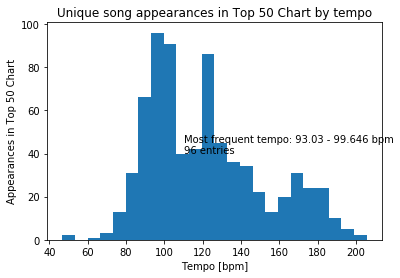

,Stat,Value
0,Max. Tempo,212.117000
1,Min. Tempo,46.718000
2,Mean,121.458016
3,Median,117.355500


In [27]:
unique_df = complete_df.drop_duplicates(subset = "id")
unique_df = unique_df[["Track Name", "tempo", "Tempo Category", "Genre"]]
unique_mode = unique_df["tempo"].mode()
unique_median = unique_df["tempo"].median()
unique_mean = unique_df["tempo"].mean()
tempo_max_unique = unique_df["tempo"].max()
tempo_min_unique = unique_df["tempo"].min()

plt.hist(unique_df["tempo"], tempo_bins)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Appearances in Top 50 Chart")
plt.title("Unique song appearances in Top 50 Chart by tempo")
plt.text(110, 40, "Most frequent tempo: 93.03 - 99.646 bpm\n96 entries")
plt.show()

unique_stats_dict = {"Stat": ["Max. Tempo", "Min. Tempo", "Mean", "Median"], "Value": [tempo_max_unique, tempo_min_unique, unique_mean, unique_median]}
unique_stats_df = pd.DataFrame(unique_stats_dict)
display(unique_stats_df)

In [28]:
unique_df["Tempo Category"].value_counts()

(93.03, 99.646]       96
(99.646, 106.262]     91
(119.494, 126.11]     86
(86.414, 93.03]       66
(126.11, 132.725]     45
(112.878, 119.494]    42
(106.262, 112.878]    40
(132.725, 139.341]    36
(139.341, 145.957]    34
(165.805, 172.421]    31
(79.798, 86.414]      31
(172.421, 179.037]    24
(179.037, 185.653]    24
(145.957, 152.573]    22
(159.189, 165.805]    20
(152.573, 159.189]    13
(73.182, 79.798]      13
(185.653, 192.269]    10
(192.269, 198.885]     5
(66.566, 73.182]       3
(198.885, 205.501]     2
(59.95, 66.566]        1
(46.718, 53.334]       1
(53.334, 59.95]        0
Name: Tempo Category, dtype: int64

In [29]:
stats.ttest_ind(complete_df["tempo"], unique_df["tempo"])

Ttest_indResult(statistic=-0.20843171986979858, pvalue=0.8348926451421976)

Our hypothesis test indicates that there is no difference between the mean value observed in a complete data set (containing all appearances in the Top 50 charts of a given song in the last three years) and the mean value observed in the set containing the unique values of songs. Since p > 0.05 for this test, we can thus accept our null hypothesis and consider that both distributions are similar. Then, tempo is a relevant factor for the popularity of a song.

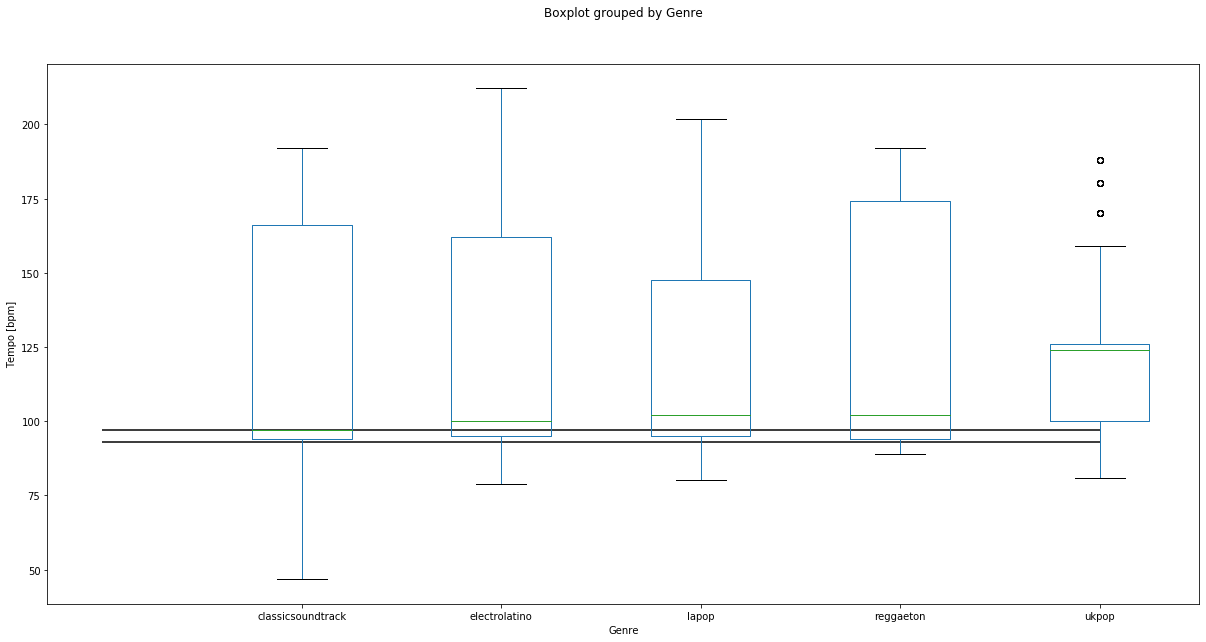

In [31]:
most_popular_df = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                  (complete_df["Genre"] == "electrolatino") |
                                  (complete_df["Genre"] == "classicsoundtrack") |
                                  (complete_df["Genre"] == "ukpop") |
                                  (complete_df["Genre"] == "reggaeton"), :]

plot = most_popular_df.boxplot("tempo", by = "Genre", grid = False, figsize = (20,10))
plot.set_ylabel("Tempo [bpm]")
plot.set_title("")
plot.hlines(93, 0, 5)
plot.hlines(97, 0, 5)
plot.fill(c = "grey")
plot

In [33]:
track_name_data_info=complete_df.groupby(["Track Name"])
track_name_data_info.count().head()

,Position,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence,id,Genre,Tempo Category
Track Name,,,,,,,,,,,,,,,,,,,,
11 Minutes (with Halsey feat. Travis Barker),10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
13 Beaches,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1950,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1999,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
24/7,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [34]:
track_name=complete_df.groupby(["Track Name"])
track_name.count().head()


,Position,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence,id,Genre,Tempo Category
Track Name,,,,,,,,,,,,,,,,,,,,
11 Minutes (with Halsey feat. Travis Barker),10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
13 Beaches,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1950,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1999,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
24/7,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [35]:
track_name_count=pd.DataFrame(track_name["Position"].count())
track_name_count.rename(columns={"Position":"Number of times in the chart TOP 50"},inplace=True)
track_name_count.head()


,Number of times in the chart TOP 50
Track Name,
11 Minutes (with Halsey feat. Travis Barker),10
13 Beaches,8
1950,14
1999,6
24/7,4


## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.

In [36]:
energy_data=pd.DataFrame(track_name["energy"].mean())
energy_data.rename(columns={"energy":"Energy"},inplace=True)
energy_data.head()


,Energy
Track Name,
11 Minutes (with Halsey feat. Travis Barker),0.852
13 Beaches,0.402
1950,0.535
1999,0.730
24/7,0.740


In [37]:
merge5_df=pd.merge(track_name_count, energy_data, on="Track Name", how="outer")
merge5_df


,Number of times in the chart TOP 50,Energy
Track Name,,
11 Minutes (with Halsey feat. Travis Barker),10,0.852
13 Beaches,8,0.402
1950,14,0.535
1999,6,0.730
24/7,4,0.740
...,...,...
the light is coming (feat. Nicki Minaj),8,0.544
the remedy for a broken heart (why am I so in love),5,0.304
when the party's over,23,0.104


In [38]:
energy_h=merge5_df["Energy"]
position_h=merge5_df["Number of times in the chart TOP 50"]
correlation1 =stats.pearsonr(energy_h,position_h)
print(f"The correlation between energy and Number of times in the chart TOP 50 factors is {round(correlation1[0],2)}")


The correlation between energy and Number of times in the chart TOP 50 factors is 0.1


y =102.15x + 10.49
The r-squared is: 0.010700967361835196


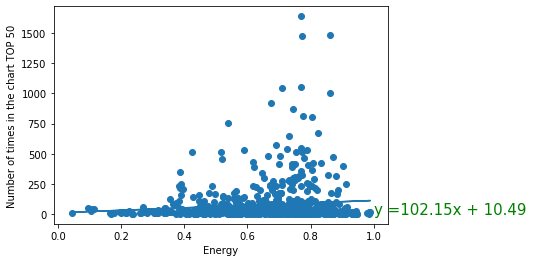

In [39]:
x_values_energyp=merge5_df["Energy"]
y_values_positionp=merge5_df["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values_energyp,y_values_positionp)
regress_values = x_values_energyp* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values_energyp, y_values_positionp)
plt.plot(x_values_energyp,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Energy")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()


In [40]:
#SAMPLE
subset=merge5_df.sample(90)
subset


,Number of times in the chart TOP 50,Energy
Track Name,,
Too Good At Goodbyes,4,0.375
Mala Mía - Remix,90,0.772
Suena El Dembow,64,0.859
Prometo,8,0.564
Mocca - Remix,81,0.758
...,...,...
White Mustang,1,0.462
Bohemian Rhapsody - Remastered 2011,204,0.396
Madura (feat. Bad Bunny),16,0.555


In [41]:
energy_s=subset["Energy"]
position_s=subset["Number of times in the chart TOP 50"]
correlation2 =stats.pearsonr(energy_s,position_s)
print(f"The correlation between both factors is {round(correlation2[0],2)}")


The correlation between both factors is 0.12


y =125.75x + -7.62
The r-squared is: 0.013712978340535068


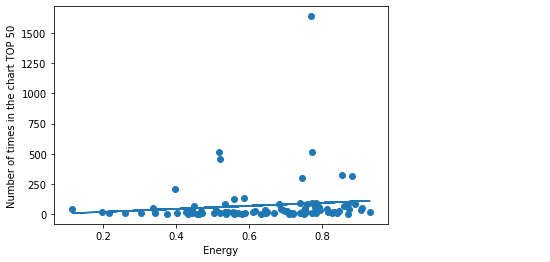

In [42]:
x_values_energys=subset["Energy"]
y_values_positions=subset["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values_energys,y_values_positions)
regress_values_sample = x_values_energys* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values_energys, y_values_positions)
plt.plot(x_values_energys,regress_values_sample)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Energy")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()


In [43]:
energy_boxplot=merge5_df["Energy"]

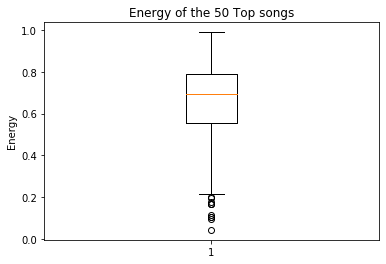

In [44]:
fig1, ax1 = plt.subplots()
ax1.set_title('Energy of the 50 Top songs')
ax1.set_ylabel('Energy')
ax1.boxplot(energy_boxplot)
plt.show()


In [45]:
quar_energy=energy_boxplot.quantile([.25,.5,.75])
lowerq_energy=quar_energy[0.25]
upperq_energy=quar_energy[0.75]
iqr_energy=upperq_energy-lowerq_energy

print(f"The lower quartile of energy is: {lowerq_energy}")
print(f"The upper quartile of energy is: {upperq_energy}")
print(f"The upper interquartile range of energy is: {iqr_energy}")
print(f"The median of energy is: {quar_energy[0.5]}")

lower_bound_energy=lowerq_energy - (1.5*iqr_energy)
upper_bound_energy=upperq_energy + (1.5*iqr_energy)
print(f"Values below {lower_bound_energy} could be the outliers.")
print(f"Values above {upper_bound_energy} could be the outliers.")


The lower quartile of energy is: 0.5545
The upper quartile of energy is: 0.7880000000000033
The upper interquartile range of energy is: 0.23350000000000326
The median of energy is: 0.6959999999999988
Values below 0.2042499999999951 could be the outliers.
Values above 1.1382500000000082 could be the outliers.


In [46]:
filter_data=(merge5_df["Energy"]>=lower_bound_energy)&(merge5_df["Energy"]<=upper_bound_energy)
merge5_df.loc[filter_data]


,Number of times in the chart TOP 50,Energy
Track Name,,
11 Minutes (with Halsey feat. Travis Barker),10,0.852000
13 Beaches,8,0.402000
1950,14,0.535000
1999,6,0.730000
24/7,4,0.740000
...,...,...
rockstar,143,0.523448
the light is coming (feat. Nicki Minaj),8,0.544000
the remedy for a broken heart (why am I so in love),5,0.304000


In [47]:
energy_wo=merge5_df[(merge5_df>lower_bound_energy).all(1)]
energy_wo


,Number of times in the chart TOP 50,Energy
Track Name,,
11 Minutes (with Halsey feat. Travis Barker),10,0.852000
13 Beaches,8,0.402000
1950,14,0.535000
1999,6,0.730000
24/7,4,0.740000
...,...,...
rockstar,143,0.523448
the light is coming (feat. Nicki Minaj),8,0.544000
the remedy for a broken heart (why am I so in love),5,0.304000


In [48]:
energy_wo_data=energy_wo["Energy"]
position_wo_data=energy_wo["Number of times in the chart TOP 50"]
correlation3 =stats.pearsonr(energy_wo_data,position_wo_data)
print(f"The correlation between both factors is {round(correlation3[0],2)}")


The correlation between both factors is 0.09


In [49]:
genre_extract_df = complete_df[["Position", "Track Name", "Artist", "Date", "id", "Genre"]]
genre_df=genre_extract_df['Genre'].value_counts()
genre_df=pd.DataFrame(genre_df)
genre_df=genre_df.sort_values('Genre',ascending=False)
genre_df=genre_df.reset_index()
genre_df=genre_df.rename(columns={'Genre':'Num of songs', 'index':'Genre'})
top15_genre_df=genre_df.nlargest(5, ['Num of songs'])
top15_genre_df

,Genre,Num of songs
0,lapop,8340
1,electrolatino,7626
2,classicsoundtrack,3531
3,ukpop,2974
4,reggaeton,2259


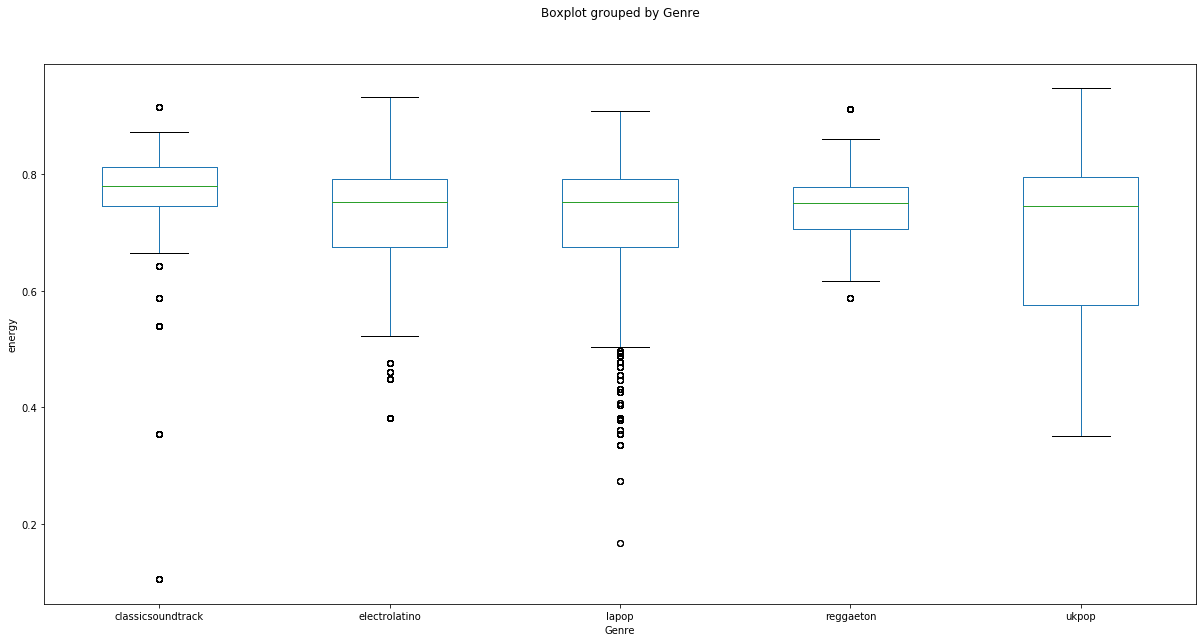

In [50]:
most_popular_df_energy = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                         (complete_df["Genre"] == "electrolatino") |
                                         (complete_df["Genre"] == "classicsoundtrack") |
                                         (complete_df["Genre"] == "ukpop") |
                                         (complete_df["Genre"] == "reggaeton"),:]

plot = most_popular_df_energy.boxplot("energy", by = "Genre", grid = False,figsize=(20,10))
plot.set_ylabel("energy")
plot.set_title("")
plot
plot

In [51]:
g1=most_popular_df_energy[most_popular_df_energy["Genre"]=="lapop"]["danceability"]
g2=most_popular_df_energy[most_popular_df_energy["Genre"]=="electrolatino"]["danceability"]
g3=most_popular_df_energy[most_popular_df_energy["Genre"]=="classicsoundtrack"]["danceability"]
g4=most_popular_df_energy[most_popular_df_energy["Genre"]=="ukpop"]["danceability"]
g5=most_popular_df_energy[most_popular_df_energy["Genre"]=="ukpop"]["danceability"]

In [52]:
stats.f_oneway(g1,g2,g3,g4,g5)

F_onewayResult(statistic=305.6158719189037, pvalue=3.1094655330479858e-257)

## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.

In [53]:
dance_data=pd.DataFrame(track_name["danceability"].mean())
dance_data.rename(columns={"danceability":"Danceability"},inplace=True)
dance_data.head()


,Danceability
Track Name,
11 Minutes (with Halsey feat. Travis Barker),0.464
13 Beaches,0.415
1950,0.600
1999,0.866
24/7,0.615


In [54]:
merge_df=pd.merge(track_name_count, dance_data, on="Track Name", how="outer")
merge_df


,Number of times in the chart TOP 50,Danceability
Track Name,,
11 Minutes (with Halsey feat. Travis Barker),10,0.464
13 Beaches,8,0.415
1950,14,0.600
1999,6,0.866
24/7,4,0.615
...,...,...
the light is coming (feat. Nicki Minaj),8,0.879
the remedy for a broken heart (why am I so in love),5,0.699
when the party's over,23,0.498


In [55]:
dance_p=merge_df["Danceability"]
position_p=merge_df["Number of times in the chart TOP 50"]
correlation4 =stats.pearsonr(dance_p,position_p)
print(f"The correlation between both factors is {round(correlation4[0],2)}")


The correlation between both factors is 0.19


y =219.91x + -72.47
The r-squared is: 0.03469924597368293


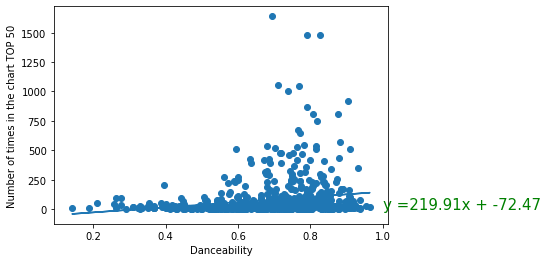

In [56]:
x_values_dancep=merge_df["Danceability"]
y_values_dposition=merge_df["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values_dancep,y_values_dposition)
regress_values2 = x_values_dancep* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values_dancep, y_values_dposition)
plt.plot(x_values_dancep,regress_values2)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Danceability")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()



In [57]:
#SAMPLE
subset_d=merge_df.sample(90)


In [58]:
dance_s=subset_d["Danceability"]
position_s=subset_d["Number of times in the chart TOP 50"]
correlation5 =stats.pearsonr(position_s,dance_s)
print(f"The correlation between both factors is {round(correlation5[0],2)}")


The correlation between both factors is 0.23


y =212.99x + -70.92
The r-squared is: 0.051197422490961896


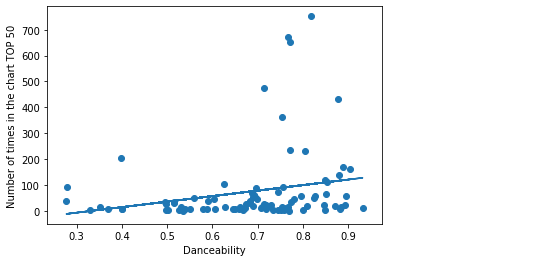

In [59]:
x_values=subset_d["Danceability"]
y_values=subset_d["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values,y_values)
regress_values = x_values* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Danceability")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()


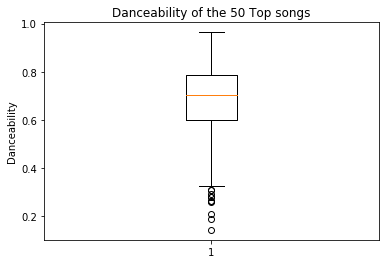

In [60]:
dance_boxplot=merge_df["Danceability"]
fig1, ax1 = plt.subplots()
ax1.set_title('Danceability of the 50 Top songs')
ax1.set_ylabel('Danceability')
ax1.boxplot(dance_boxplot)
plt.show()


In [61]:
quartiles_dance=dance_boxplot.quantile([.25,.5,.75])
lowerq_dance=quartiles_dance[0.25]
upperq_dance=quartiles_dance[0.75]
iqr_dance=upperq_dance-lowerq_dance

print(f"The lower quartile of danceability is: {lowerq_dance}")
print(f"The upper quartile of danceability is: {upperq_dance}")
print(f"The upper interquartile range of danceability is: {iqr_dance}")
print(f"The median of danceability is: {quartiles_dance[0.5]}")


The lower quartile of danceability is: 0.5994999999999999
The upper quartile of danceability is: 0.7874999999999992
The upper interquartile range of danceability is: 0.18799999999999928
The median of danceability is: 0.703


In [62]:
lower_bound_dance=lowerq_dance - (1.5*iqr_dance)
upper_bound_dance=upperq_dance + (1.5*iqr_dance)
print(f"Values below {lower_bound_dance} could be the outliers.")
print(f"Values above {upper_bound_dance} could be the outliers.")


Values below 0.317500000000001 could be the outliers.
Values above 1.0694999999999981 could be the outliers.


In [63]:
dance_wo=merge_df[(merge_df>=lower_bound_dance).all(1)]
dance_wo


,Number of times in the chart TOP 50,Danceability
Track Name,,
11 Minutes (with Halsey feat. Travis Barker),10,0.464
13 Beaches,8,0.415
1950,14,0.600
1999,6,0.866
24/7,4,0.615
...,...,...
the light is coming (feat. Nicki Minaj),8,0.879
the remedy for a broken heart (why am I so in love),5,0.699
when the party's over,23,0.498


In [64]:
danc=dance_wo["Danceability"]
pos=dance_wo["Number of times in the chart TOP 50"]
corr =stats.pearsonr(danc,pos)
print(f"The correlation between both factors is {round(corr[0],2)}")


The correlation between both factors is 0.19


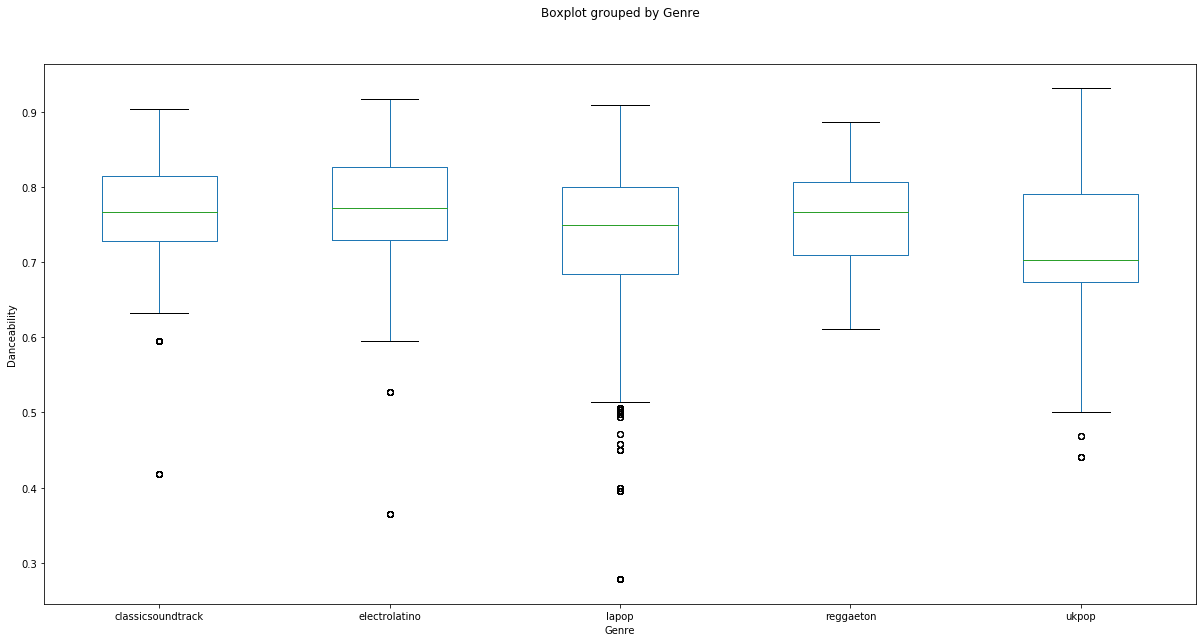

In [65]:
most_popular_df_dance = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                         (complete_df["Genre"] == "electrolatino") |
                                         (complete_df["Genre"] == "classicsoundtrack") |
                                         (complete_df["Genre"] == "ukpop") |
                                         (complete_df["Genre"] == "reggaeton"),:]

plot = most_popular_df_dance.boxplot("danceability", by = "Genre", grid = False,figsize=(20,10))
plot.set_ylabel("Danceability")
plot.set_title("")
plot
plot

In [66]:
group1=most_popular_df_dance[most_popular_df_dance["Genre"]=="lapop"]["danceability"]
group2=most_popular_df_dance[most_popular_df_dance["Genre"]=="electrolatino"]["danceability"]
group3=most_popular_df_dance[most_popular_df_dance["Genre"]=="classicsoundtrack"]["danceability"]
group4=most_popular_df_dance[most_popular_df_dance["Genre"]=="ukpop"]["danceability"]
group5=most_popular_df_dance[most_popular_df_dance["Genre"]=="ukpop"]["danceability"]

In [67]:
stats.f_oneway(group1,group2,group3,group4,group5)

F_onewayResult(statistic=305.6158719189037, pvalue=3.1094655330479858e-257)

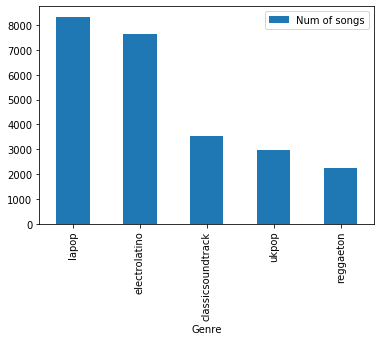

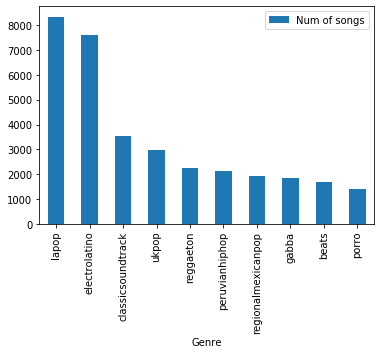

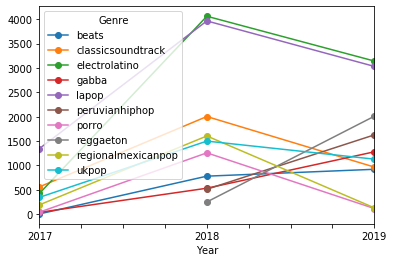

In [69]:
top15_genre_df.plot.bar(x='Genre',y = 'Num of songs')
genre_extract_df = complete_df[["Position", "Track Name", "Artist", "Date", "id", "Genre"]]
genre_df=genre_extract_df['Genre'].value_counts()
genre_df=pd.DataFrame(genre_df)
genre_df=genre_df.sort_values('Genre',ascending=False)
genre_df=genre_df.reset_index()
genre_df=genre_df.rename(columns={'Genre':'Num of songs', 'index':'Genre'})
top15_genre_df=genre_df.nlargest(10, ['Num of songs'])
top15_genre_df
top15_genre_df.plot.bar(x='Genre',y = 'Num of songs')
genre_per_date_df = complete_df[["Date", "Genre"]]
genre_per_date_df=genre_per_date_df.sort_values('Date',ascending=True)
genre_per_date_df['Year']=genre_per_date_df['Date'].str[:4]
genre_per_year_df=genre_per_date_df[['Genre','Year']]
# genre_per_year_df
most_popular_genres_df = genre_per_year_df.loc[(genre_per_year_df["Genre"] == "lapop")|
                                               (genre_per_year_df["Genre"] == "electrolatino") |
                                               (genre_per_year_df["Genre"] == "classicsoundtrack") |
                                               (genre_per_year_df["Genre"] == "ukpop")|
                                               (genre_per_year_df["Genre"] == "reggaeton")|
                                               (genre_per_year_df["Genre"] == "peruvianhiphop") |
                                               (genre_per_year_df["Genre"] == "regionalmexicanpop") |
                                               (genre_per_year_df["Genre"] == "gabba") |
                                               (genre_per_year_df["Genre"] == "beats") |
                                               (genre_per_year_df["Genre"] == "porro"),:]
most_popular_genres_df=most_popular_genres_df.reset_index()
genre_count=most_popular_genres_df.groupby(['Year'])
genre_count=genre_count['Genre'].value_counts()
genre_count=pd.DataFrame(genre_count)
genre_count=genre_count.rename(columns={'Genre':'Num of songs'})
genre_count=genre_count.reset_index()
genre_count
genre_count.pivot_table('Num of songs', 'Year', 'Genre').plot(kind='line', marker='o')